# Metody Programowania Równoległego
*Temat: Message Passing Interface*

Wykonał: **Paweł Kruczkiewicz**

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Część pierwsza - Komunikacja PP
W tej części zbadano, jakie są ograniczenia w komunikacji międzywęzłowej oraz w obrębie jednego węzła w komunikacji równoległej. Porównano dwa typy komunikacji: buforowaną `Bsend` oraz niebuforowaną `Send`.

### Kod Programu
Do wykonania pomiarów posłużono się poniżej przedstawionym programem napisanym w języku C:
    
```C
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <mpi.h>
#include <math.h>

#define N 1001
#define DEFAULT_TAG 0
#define TEST_CASES_NUM 19
#define CSV_NAME "results/normal_1_node.csv"
#define BUFFERED 1

void init_mpi(int* argc, char** argv[], int* rank, int* size){
   MPI_Init (argc, argv);  /* starts MPI */
  MPI_Comm_rank (MPI_COMM_WORLD, rank);  /* get current process id */
  MPI_Comm_size (MPI_COMM_WORLD, size);  /* get number of processes */
}

void my_MPI_send(int* number_buf, int number_amount, int receiver) {
  # ifdef BUFFERED
   int buffer_attached_size = MPI_BSEND_OVERHEAD +  number_amount*sizeof(int);
   char* buffer_attached = (char*) malloc(buffer_attached_size);
   MPI_Buffer_attach(buffer_attached, buffer_attached_size);

   MPI_Bsend(number_buf, number_amount, MPI_INT, receiver, DEFAULT_TAG, MPI_COMM_WORLD);

   MPI_Buffer_detach(&buffer_attached, &buffer_attached_size);
   free(buffer_attached); 
  # else
  MPI_Send(number_buf, number_amount, MPI_INT, receiver, DEFAULT_TAG, MPI_COMM_WORLD);
  # endif /* BUFFERED */

}


void my_MPI_receive(int* number_buf, int number_amount, int sender){
  MPI_Recv(number_buf, number_amount, MPI_INT, sender, DEFAULT_TAG, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
}

void MPI_one_ping_pong(int rank, int* number_buf, int number_amount) {
  if (rank == 0) {
    my_MPI_send(number_buf, number_amount, 1);
        my_MPI_receive(number_buf, number_amount, 1);
  } else if (rank == 1) {
        my_MPI_receive(number_buf, number_amount, 0); 
    my_MPI_send(number_buf, number_amount, 0);
  }
}

int* init_buf(int n){
  int* buf = (int*) malloc(sizeof(int) * n);
  int i;
  for (i=0; i < n; i++){
     buf[i] = -1;
  }
  return buf;
}

double* init_double_table(int n){
   return (double*) malloc(sizeof(double) * n);
}

double avg(double* nums, int n){
   int i;
   double sum = 0;
   for (i = 0; i < n; i++){
       sum += nums[i];
   }
   return sum / (double) n;
}

double std(double* nums, double mean, int n){
   double result = 0;
   int i;
   for (i = 0; i < n; i++){
      result += (nums[i] - mean)*(nums[i] - mean);
   }   

   return (double) sqrt(result / (double) (n - 1));  
}

void measure_ping_pong_times(double* times, int rank, int number_amount) {

  int i;
  double t1, t2;
  int* number_buf = init_buf(number_amount);

  MPI_Barrier(MPI_COMM_WORLD);

  for (i = 0; i < N; i++){
     t1 = MPI_Wtime();
     MPI_one_ping_pong(rank, number_buf, number_amount);    
     t2 = MPI_Wtime();
     times[i] = t2 - t1;
  } 

  free(number_buf);
}

double compute_thrtp(double time_in_sec, int number_amount) {
  int buff_size = sizeof(int)*number_amount;
  return (double) (8*buff_size)/(1000000.0*time_in_sec);
}

double* compute_thrtp_measures(double* results, double* times_in_sec, int number_of_measures, int number_amount){
  int i;
  for (i = 0; i < number_of_measures; i++){
     results[i] = compute_thrtp(times_in_sec[i], number_amount);
  }
  return results;
}

void export_to_csv(int* buff_size, double* throughtputs, double* stds) {
  printf("Message_size, Throughtput, Standard deviation\n");

  int i;
  for (i = 0; i < TEST_CASES_NUM; i++) {
    printf( "%d, %f, %f\n", buff_size[i], throughtputs[i], stds[i]);
  }
}

int main (int argc, char * argv[])
{
  int rank, size;
  init_mpi(&argc, &argv, &rank, &size);

  const int number_amounts[TEST_CASES_NUM] = {10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000, 2000000, 5000000, 10000000};

  double* thrtps = (double*) malloc(sizeof(double)*TEST_CASES_NUM);
  double* stds = (double*) malloc(sizeof(double)*TEST_CASES_NUM);

  int* buff_size = (int*) malloc(sizeof(int)*TEST_CASES_NUM);
  double* thrtp_measures = (double*) malloc(sizeof(double)*N);
  double* time_measures = (double*) malloc(sizeof(double)*N);
  int i;  
  for (i = 0; i < TEST_CASES_NUM; i++) {
        measure_ping_pong_times(time_measures, rank, number_amounts[i]);
        compute_thrtp_measures(thrtp_measures, time_measures, N, number_amounts[i]);
        buff_size[i] = sizeof(int)*number_amounts[i];

        thrtps[i] = avg(thrtp_measures, N); 
        stds[i] = std(thrtp_measures, thrtps[i], N);
  } 
  measure_ping_pong_time(time_measures, rank, 1);
  double delay = 1000.0 * avg(measure_ping_pong_time, N);  

  if (rank == 0) {
     export_to_csv(buff_size, thrtps, stds);
     printf("%f\n", delay);
    
  }  
  free(thrtps);
  free(stds);
  free(buff_size);

  free(time_measures);
  free(thrtp_measures);

MPI_Finalize();

  return 0;
}
```

Był on kompilowany bez i z flagą `-DBUFFERED` w celu zbadania odpowiednio komunikacji niebuforowanej i buforowanej. 

Wyniki pobrano zarówno dla komunikacji na 1 nodzie, jak i pomiędzy 2 node'ami (dla obu typów komunikacji). Komunikacja na 1 nodzie odbyła się po ustawieniu `:2` przy nodzie nr 1 w pliku `allnodes`, a komunikacja między 2 odbyła się przy ustawieniu  `:1` przy nodach nr 9 i 10.

### Dane pomiarowe

W wyniku eksperymentu uzyskano 5 plików CSV. 4 z nich odnosiły się do przepustowości, 1 do opóźnienia. 
Dane pozyskano w czasie, w którym na klastrze nie znajdował się żaden inny użytkownik poza osobą przeprowadzającą eksperyment, co sprawdzono za pomocą komendy `who`.

#### Przepustowość od wielości danych

Czas przesyłu danych liczony był jako czas potrzebny na przesłanie `x` B danych w dwie strony. Seria wielkości danych rosła wg zasady "złotówkowej": liczba przesyłanych pakietów rosła wg zasady 10 B, 20 B, 50 B, 100 B, 200 B itd. aż do 10 MB. Każdy pomiar powtórzono 1001 razy. Przedstawione niżej dane sa wartością oczekiwaną.

Przepustowość została zapisana w Mbit/s, wielkość danych w B. Są to 4 pliki: 
  1. komunikacja niebuforowana - 1 node


In [27]:
normal_1_node = pd.read_csv("results/normal_1_node.csv")
normal_1_node

,Message_size,Throughtput,Standard deviation
0,40,481.959011,133.074453
1,80,896.533751,202.889048
2,200,1847.578202,463.344575
3,400,3493.253625,851.583263
4,800,5935.038209,1366.372621
5,2000,10297.992164,2366.957090
6,4000,14637.307694,2898.917984
7,8000,17519.903217,2925.604689
8,20000,18106.109899,2349.672136
9,40000,19934.435952,2357.607317


2. komunikacja niebuforowana - 2 nody

In [28]:
normal_2_nodes = pd.read_csv("results/normal_2_nodes.csv")
normal_2_nodes

,Message_size,Throughtput,Standard deviation
0,40,3.392503,0.385705
1,80,6.544158,0.378377
2,200,16.939024,0.940622
3,400,35.082844,1.651974
4,800,68.320965,4.091352
5,2000,114.919114,5.533133
6,4000,225.507368,9.900137
7,8000,436.795716,17.104775
8,20000,841.597299,25.730978
9,40000,1348.783032,229.789901


3. komunikacja buforowana - 1 node

In [29]:
buf_1_node = pd.read_csv("results/buffered_1_node.csv")
buf_1_node

,Message_size,Throughtput,Standard deviation
0,40,345.957066,78.465837
1,80,643.597247,104.427955
2,200,1353.094855,330.036890
3,400,2659.618362,497.336282
4,800,4420.255053,910.331676
5,2000,6870.885482,1256.534152
6,4000,8895.936292,1663.113445
7,8000,11268.527625,1707.019489
8,20000,13907.907531,1791.074330
9,40000,14514.982582,1879.560144


4. komunikacja buforowana - 2 nody

In [30]:
buf_2_nodes = pd.read_csv("results/buffered_2_nodes.csv")
buf_2_nodes

,Message_size,Throughtput,Standard deviation
0,40,3.641098,0.284831
1,80,7.270346,0.353929
2,200,18.194014,0.990094
3,400,36.118314,2.109843
4,800,71.910043,3.979640
5,2000,108.548712,4.991827
6,4000,213.367019,7.796481
7,8000,407.241770,16.194272
8,20000,800.539674,53.475420
9,40000,1288.280043,213.881578


## Wykresy

In [31]:


def plot_line(x, y1, y2, e1, e2, title, x_label, y_label, y1_label, y2_label):
    plt.figure(figsize=(10, 7), dpi=80)

    plt.errorbar(x, y1, e1, label=y1_label, marker="o")
    plt.errorbar(x, y2, e2, label=y2_label, marker="^")
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    plt.legend()
    plt.show()



### Porównanie przepustowości dla różnych typów komunikacji na 1 nodzie.

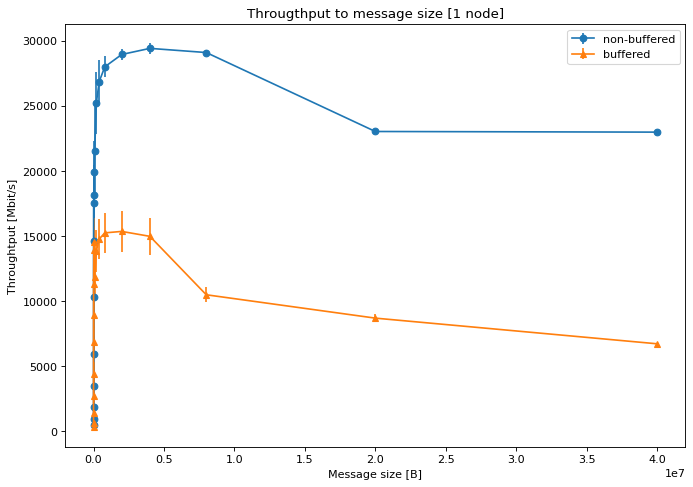

In [32]:
x = normal_1_node["Message_size"]
y1 = normal_1_node[" Throughtput"]
y2 = buf_1_node[" Throughtput"]
e1 = normal_1_node[" Standard deviation"]
e2 = buf_1_node[" Standard deviation"]

plot_line(x, y1, y2, e1=e1, e2=e2,
              title="Througthput to message size [1 node]",
              x_label="Message size [B]",
              y_label="Throughtput [Mbit/s]",
              y1_label="non-buffered", y2_label="buffered")


Zagadkowym jest spadek dla wartości większych niż 10 MB. Wysył tak dużych pakietów jest już nieopłacalny.



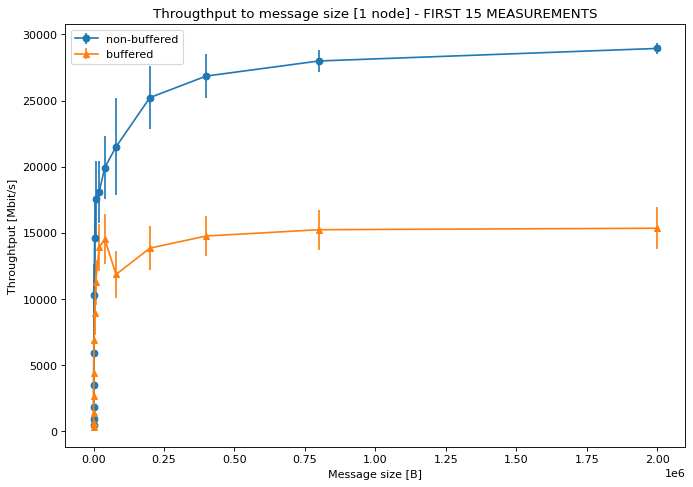

In [33]:
x = normal_1_node["Message_size"][:15]
y1 = normal_1_node[" Throughtput"][:15]
y2 = buf_1_node[" Throughtput"][:15]
e1 = normal_1_node[" Standard deviation"][:15]
e2 = buf_1_node[" Standard deviation"][:15]

plot_line(x, y1, y2, e1=e1, e2=e2,
              title="Througthput to message size [1 node] - FIRST 15 MEASUREMENTS",
              x_label="Message size [B]",
              y_label="Throughtput [Mbit/s]",
              y1_label="non-buffered", y2_label="buffered")



Powyższy wykres jest zbliżony do oczekiwanego (może z wyjątkiem nagłego spadku dla 80 kB, jednak jest to prawdopodobnie znów związane z infrastrukturą vClustra). Nasycenie wykresu dla wartości oczekiwanej osiągane jest już przy około 100 kB przeyłanych danych i wynosi ok 15 Gbit/s. Dla niebuforowanej wartości są większe: nasycenie w granicach 27 Gbit/s osiągane jest przy ok. 200 kB przesyłanej wiadomości.


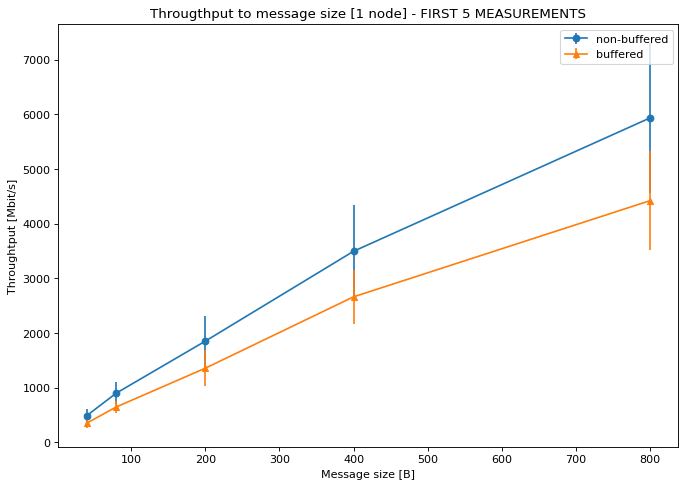

In [34]:


x = normal_1_node["Message_size"][:5]
y1 = normal_1_node[" Throughtput"][:5]
y2 = buf_1_node[" Throughtput"][:5]
e1 = normal_1_node[" Standard deviation"][:5]
e2 = buf_1_node[" Standard deviation"][:5]

plot_line(x, y1, y2, e1=e1, e2=e2,
              title="Througthput to message size [1 node] - FIRST 5 MEASUREMENTS",
              x_label="Message size [B]",
              y_label="Throughtput [Mbit/s]",
              y1_label="non-buffered", y2_label="buffered")





Warto zauważyć, że w przypadku komunikacji w obrębie jednego węzła dużo lepiej sprawdza się komunikacja niebuforowana. Jest pozornie wbrew oczekiwaniom, ponieważ wartość buforowana powinna w przypadku małych komunikatów usprawniać ich przesył. Zaistniałą sytuację można tłumaczyć tym, że narzut na stworzenie bufora sprawia, że jest on mniej wydajny. Bufor tworzony jest zazwyczaj w celu zmniejszenia problemu dużych opóźnień, a dla tego typu komunikacji nie jest on duży (dowód w kolejnych punktach).

### Porównanie przepustowości dla różnych typów komunikacji na 2 nodach.

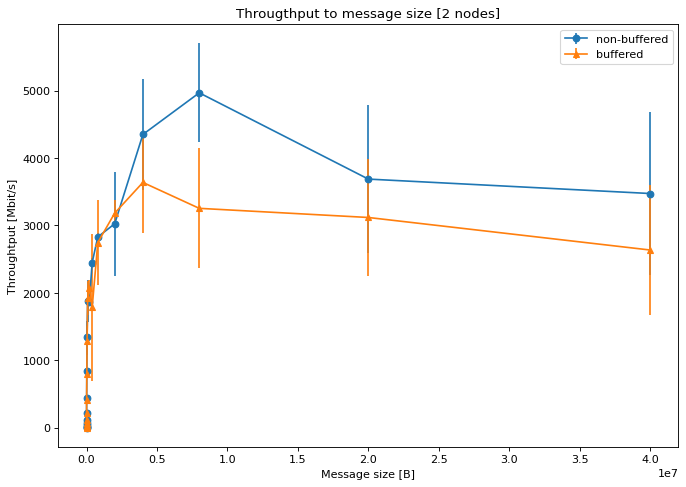

In [35]:
x = normal_2_nodes["Message_size"]
y1 = normal_2_nodes[" Throughtput"]
y2 = buf_2_nodes[" Throughtput"]
e1 = normal_2_nodes[" Standard deviation"]
e2 = buf_2_nodes[" Standard deviation"]
plot_line(x, y1, y2, e1, e2,
              title="Througthput to message size [2 nodes]",
              x_label="Message size [B]",
              y_label="Throughtput [Mbit/s]",
              y1_label="non-buffered", y2_label="buffered")



Tutaj znów mamy do czynienia z nieoczekiwanymi spadkami dla dżych wartości spowodowanymi najprawdopodobniej zabezpieczeniami vClustra. Widać jednak, że nasycenie dla komunikacji buforowanej i niebuforowanej wynosi w przybliżeniu kolejno 3Gb/s oraz 4Gb/s.

Co również oczekiwane - szybkość komunikacji między dwoma węzłami jest zdecydowanie mniejsza niż w obrębie jednego węzła.

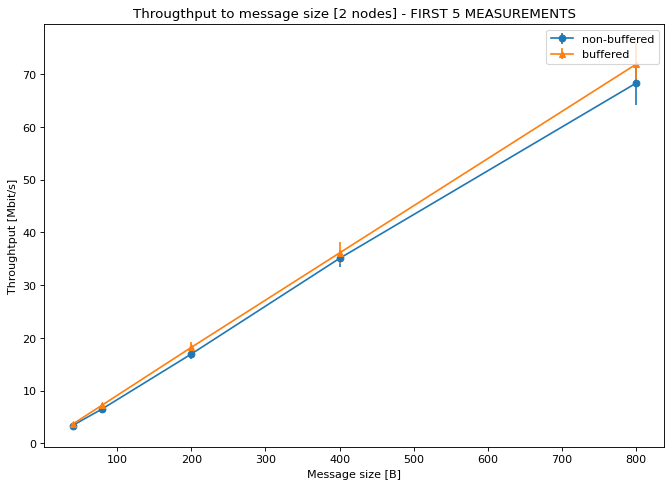

In [36]:


x = normal_2_nodes["Message_size"][:5]
y1 = normal_2_nodes[" Throughtput"][:5]
y2 = buf_2_nodes[" Throughtput"][:5]
e1 = normal_2_nodes[" Standard deviation"][:5]
e2 = buf_2_nodes[" Standard deviation"][:5]
plot_line(x, y1, y2, e1, e2,
              title="Througthput to message size [2 nodes] - FIRST 5 MEASUREMENTS",
              x_label="Message size [B]",
              y_label="Throughtput [Mbit/s]",
              y1_label="non-buffered", y2_label="buffered")



Z powyższego wykresu widzimy, że komunikacja buforowana pozytywnie wpływa na przepustowość komunikacji, ponieważ niweluje opóźnienie, które jest w przypadku komunikacji międzywęzłowej większe.

### Opóźnienie

Odczytano 4 wielkości opóźnienia dla wszystkich 4 konfiguracji eksperymentu. Została ona obliczona jako długość przesyłu w obie strony komunikatu o wielkości 1 B. Wartość opóźnienia zapisano w ms.

In [37]:
delays = pd.read_csv("results/delays.csv")
delays

,Type,Number_of_nodes,Delay
0,normal,1,0.000666
1,normal,2,0.147370
2,buffered,1,0.000974
3,buffered,2,0.076020


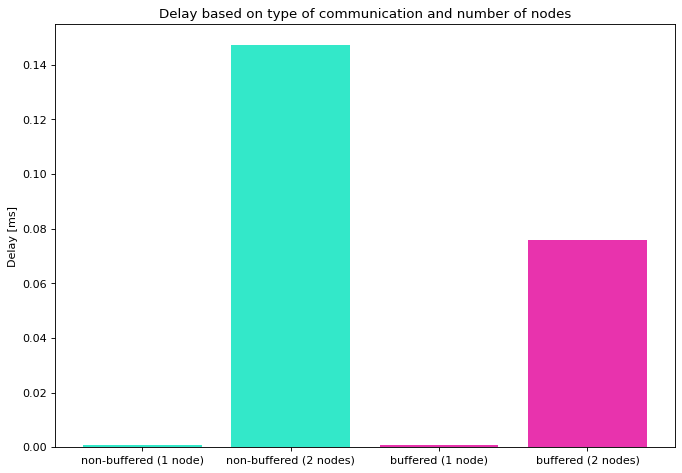

In [38]:
labels = ["non-buffered (1 node)", "non-buffered (2 nodes)", "buffered (1 node)", "buffered (2 nodes)"]
y = delays[" Delay"]
colors = ["#33e8c9", "#33e8c9", "#e833ad", "#e833ad"]
plt.figure(figsize=(10, 7), dpi=80)
plt.bar(labels, y, color=colors)
plt.title("Delay based on type of communication and number of nodes")
plt.ylabel("Delay [ms]")
plt.show()



Powyższy wykres pokazuje, że buforowanie jest szczególnie korzystne dla komunikacji między dwoma węzłami. Wartość opóźnienia nie zmienia się tak bardzo dla komunikacji buforowanej, czego nie można powiedzieć o komunikacji niebuforowanej, gdzie wartość ta jest niemal dwa razy niższa dla komunikacji międzywęzłowej w porównaniu z komunicją w jednym węźle.

Widać również, że opóźnienia w komunikacji miedzywęzłowej są kilka rzędów wielkości większe niż dla komunikacji w ramach jednego węzła.


## Część druga - badania równoległości programu równoległego

Ta część sprawozdania zajmuje się badaniem równoległości programu wyliczającego liczbę PI metodą Monte Carlo. Temat ten dotyczył laboratoriów drugich oraz trzecich.

### Kod

#### Programy wyliczające liczbę PI

##### *`monte-weak.c` - słaba skalowalność*

Program wyliczający liczbę PI metodą Monte Carlo. Mierzy czas działania. Wynikiem jest wiersz pliku CSV (szczegóły: patrz skrypt). Wykorzystuje OpenMPI w C. Wielkość problemu definiuje się przez makro N.  
```C
#include <stdio.h>
#include <stdlib.h>
#include <mpi.h>
#include <time.h>
#include <math.h>

#ifndef N
#define N 100000000
#endif /*N*/

#define SCALING "weak"

#ifndef TEST_CASE_NUM
#define TEST_CASE_NUM 0
#endif /*TEST_CASE_NUM*/
typedef struct Point {
  float x;
  float y;
} Point;

void init_mpi(int* argc, char** argv[], int* rank, int* size){
   MPI_Init (argc, argv);  /* starts MPI */
  MPI_Comm_rank (MPI_COMM_WORLD, rank);  /* get current process id */
  MPI_Comm_size (MPI_COMM_WORLD, size);  /* get number of processes */
}

int point_in_circle() {
   Point p;
   p.x = (float) rand() / (float) RAND_MAX;
   p.y = (float) rand() / (float) RAND_MAX;

  return (p.x*p.x + p.y*p.y) < 1;
}

long long draw_points_in_circle(long long n) {
  long long i;
  long long sum = 0;
  for ( i = 0; i < n; i++){
       sum += point_in_circle();
  }
   return sum;
}

float approx_pi(long long sum, long long processes_num){
  double proportion = (double) sum / (double) (N*processes_num);
  return 4*proportion;
}

int main (int argc, char * argv[])
{
  int rank, size;

  init_mpi(&argc, &argv, &rank, &size);

  srand(time(NULL) + rank);

  long long n_per_process = N;

  MPI_Barrier(MPI_COMM_WORLD);

  double t1 = MPI_Wtime();
  long long local_sum = draw_points_in_circle(n_per_process);

  long long global_sum;
  MPI_Reduce(&local_sum, &global_sum, 1, MPI_LONG_LONG_INT, MPI_SUM, 0, MPI_COMM_WORLD);
  double t2 = MPI_Wtime();
  double total_time = t2 - t1;

  if (rank == 0){
        double pi = approx_pi(global_sum, size);
        printf("%f,%f,%d,%d,%s,%d\n", pi, total_time, size, N, SCALING, TEST_CASE_NUM);
  }
  MPI_Finalize();

  return 0;
}
```

##### *`monte.c` - silna skalowalność*

Niemal ten sam plik co `monte_weak.c`, lecz inaczej wyliczana jest liczba pi oraz liczba punktów dla procesora. W wynikowej linii dodaje informację o skalowaniu
```C
#include <stdio.h>
#include <stdlib.h>
#include <mpi.h>
#include <time.h>
#include <math.h>

#ifndef N
#define N 100000000
#endif

#define SCALING "strong"

#ifndef TEST_CASE_NUM
#define TEST_CASE_NUM 0
#endif

typedef struct Point {
  float x;
  float y;
} Point;

void init_mpi(int* argc, char** argv[], int* rank, int* size){
   MPI_Init (argc, argv);  /* starts MPI */
  MPI_Comm_rank (MPI_COMM_WORLD, rank);  /* get current process id */
  MPI_Comm_size (MPI_COMM_WORLD, size);  /* get number of processes */
}

int point_in_circle() {
   Point p;
   p.x = (float) rand() / (float) RAND_MAX;
   p.y = (float) rand() / (float) RAND_MAX;

  return (p.x*p.x + p.y*p.y) < 1;
}

long long draw_points_in_circle(long long n) {
  long long i;
  long long sum = 0;
  for ( i = 0; i < n; i++){
       sum += point_in_circle();
  }
   return sum;
}

float approx_pi(long long sum){
  double proportion = (double) sum / (double) N;
  return 4*proportion;
}

int main (int argc, char * argv[])
{
  int rank, size;

  init_mpi(&argc, &argv, &rank, &size);

  srand(time(NULL) + rank);

  long long n_per_process = N / size;

  MPI_Barrier(MPI_COMM_WORLD);

  double t1 = MPI_Wtime();
  long long local_sum = draw_points_in_circle(n_per_process);

  long long global_sum;
  MPI_Reduce(&local_sum, &global_sum, 1, MPI_LONG_LONG_INT, MPI_SUM, 0, MPI_COMM_WORLD);
  double t2 = MPI_Wtime();
  double total_time = t2 - t1;

  if (rank == 0){
        double pi = approx_pi(global_sum);
        printf("%f,%f,%d,%d,%s,%d\n", pi, total_time, size, N, SCALING, TEST_CASE_NUM);
  }
  MPI_Finalize();

  return 0;
}
```

#### Skrypt

Skrypt ma za zadanie wygenerować plik CSV z wszystkimi danymi pomiarowymi. Większość danych dotyczy wyniku (PI, czas wykonania), pozostałe dotyczą parametrów wykonania (liczba procesorów, wielkość problemu = N, typ skalowania).
Każda konfiguracja została powtórzona 15 razy. Numer powtórzenia znajduje się w wierszu TEST_CASE_NUM
```bash
#!/bin/bash -l
#SBATCH --nodes 1
#SBATCH --ntasks 12
#SBATCH --time=04:00:00
#SBATCH --partition=plgrid
#SBATCH --account=plgmpr23-cpu

module add .plgrid plgrid/tools/openmpi

function mpi_run() {
    mpicc -o "$1.o" "$1.c" -lm "$3" "$4"
    mpiexec -np "$2" "./$1.o"
    rm "$1.o"
}

echo "PI,TIME,PROC_NUM,N,SCALING,TEST_CASE_NUM"
for N in 1000000 100000000 1410065408
do
        for proc_num in {1..12}
        do
                for test_case_num in {1..15}
                do
                        mpi_run monte $proc_num -DN=$N -DTEST_CASE_NUM=$test_case_num
                        mpi_run monte_weak $proc_num -DN=$N -DTEST_CASE_NUM=$test_case_num
                done
        done
done
```

Niestety, przypisany czas 4 godzin nie był wystarczający, aby powyższy skrypt dobiegł końca. Otrzymano wyniki bez pełnego ostatniego wykonania pierwszej pętli. Należało rozpocząć obliczenia od liczby procesorów równej 2. W tym celu napisano kolejny skrypt. Zmniejszono w nim liczbę powtórzeń do 10.

```bash
#!/bin/bash -l
#SBATCH --nodes 1
#SBATCH --ntasks 12
#SBATCH --time=12:00:00
#SBATCH --partition=plgrid
#SBATCH --account=plgmpr23-cpu

module add .plgrid plgrid/tools/openmpi

function mpi_run() {
    mpicc -o "$1.o" "$1.c" -lm "$3" "$4"
    mpiexec -np "$2" "./$1.o"
    rm "$1.o"
}

echo "PI,TIME,PROC_NUM,N,SCALING,TEST_CASE_NUM"
for N in 1410065408
do
        for proc_num in {2..12}
        do
                for test_case_num in {1..10}
                do
                        mpi_run monte $proc_num -DN=$N -DTEST_CASE_NUM=$test_case_num
                        mpi_run monte_weak $proc_num -DN=$N -DTEST_CASE_NUM=$test_case_num
                done
        done
done
```

### Dane

W wyniku działania przedstawionych wyżej skryptów  stworzono plik `results.csv` z wynikami wszystkich eksperymentów. Dane pozyskano za pomocą użycia trybu wsadowego na komputerze ARES - pierwszy sktypt wykonywał się 4 godziny, drugi ok. 3 h. Następnie wybrano z plików odpowiednie wiersze i stworzono wykorzystywany niżej plik.

In [39]:
pi_results = pd.read_csv("result.csv")
pi_results["N"] = pi_results["N"].astype("category")
pi_results.head()

,PI,TIME,PROC_NUM,N,SCALING,TEST_CASE_NUM
0,3.144872,0.034602,1,1000000,strong,1
1,3.138092,0.035147,1,1000000,weak,1
2,3.141400,0.035292,1,1000000,strong,2
3,3.141272,0.035351,1,1000000,weak,2
4,3.140540,0.034781,1,1000000,strong,3


Na początek sprawdźmy, czy nasze zwróciły dobry wynik. Poniżej użyto kodu, który wylicza średnią wartość oraz odchylenie standardowe, a także sprawdza, czy wszystkie wartości mieszczą się między 0 a 4.

In [40]:
def is_pi_all_right(df):
    pi_values = np.array(df["PI"])
    all_values_between_0_and_4 = all(pi_values > 0) and all(pi_values < 4)
    
    print(f"Mean value: {pi_values.mean()}")
    print(f"Std: {pi_values.std()}")
    print(f"Are all alues between 0 and 4: {all_values_between_0_and_4}")
    
is_pi_all_right(pi_results)
    
    

Mean value: 3.1415992391991567
Std: 0.0008072376519102167
Are all alues between 0 and 4: True


Program zwrócił właściwe wyniki. Możemy przedstawić to również w postaci wykresu pudełkowego. Został on dodatkowo podzielony ze względu na parametr N.

<AxesSubplot:xlabel='PI', ylabel='N'>

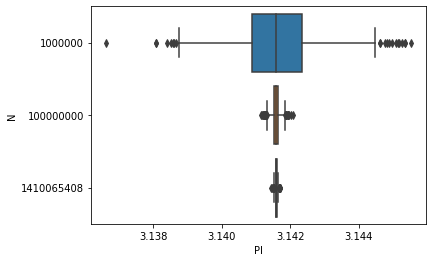

In [41]:
sns.boxplot(data=pi_results, x="PI", y="N")

Widzimy, że wraz z większą liczbą punktów wzrasta dokładność pomiarów. Tego należało się spodziewać.

### Wykresy

Poniżej zamieszczono wykresy, które próbują lepiej zobrazować zebrane dane na temat przyśpieszenia zrównoleglonego programu. Do każdej z 6 konfiguracji (2 typy skalowalności (silna i słaba) * 3 wielkości problemu) stworzono wykres:
  - czasu od liczby procesorów
  - przyśpieszenia od liczby procesorów
  - efektywności od liczby procesorów
  - części sekwencyjnej od liczby procesorów.
  
Wszystkie wartości prezentowane są dla wartości od 2 procesorów do 12. Jest tak, ponieważ wartość cześci sekwencyjnej dla 1 procesora jest nieoznaczona. Dla zachowania jednolitości "brak podziałki na 1" pozostawiono również na pozostałych wykresach.

In [42]:
def compute_speedup(times, number_of_processors, t_s, scaling):
    return t_s / times if scaling == "strong" else number_of_processors * (t_s / times)

def compute_efficiency(speedup, n):
    return speedup / n

def compute_serial_fraction(speedup, n):
    numerator = 1/speedup - 1/n 
    denominator = 1 - 1/n
    return numerator/denominator

def mean_for_process(data, processors, fixed_p):
    data_for_fixed_p = data[processors == fixed_p]
    return data_for_fixed_p.mean()

def std_for_process(data, processors, fixed_p):
    data_for_fixed_p = data[processors == fixed_p]
    return data_for_fixed_p.std()


def plot_line_with_errors(x, y, e, title, x_label, y_label, ymax, diagonal=False, hline=None):
    f, ax = plt.subplots(1)
    f.set_size_inches(10,7)

    ax.errorbar(x, y, e, marker="o", linestyle="--")
    if diagonal: ax.plot(x, x, linestyle="--")
    if hline: ax.axhline(hline, linestyle="--", color="red")
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax.set_xlim(xmin=0, xmax=13)
    ax.set_ylim(ymin=0, ymax=ymax)

    plt.show(f)


def show_graph(measure, processors, y_label, title, diagonal=False, ymax=1.2, hline=None):
    unique_ps = np.unique(processors)
    y = [mean_for_process(measure, processors, p) for p in unique_ps]
    e = [std_for_process(measure, processors, p) for p in unique_ps]
    
    plot_line_with_errors(x=unique_ps, y=y, e=e, y_label=y_label, title=title, x_label="Number of processes", ymax=ymax, diagonal=diagonal, hline=hline)
    

def show_graphs_for_one_configuration(df, scaling, N):
    df_for_configuration = df[np.bitwise_and(df["SCALING"] == scaling, df["N"] == N)]
    df_2_or_more_proc = df_for_configuration[df_for_configuration["PROC_NUM"] >= 2]
    
    t_s = df_for_configuration[df_for_configuration["PROC_NUM"] == 1]["TIME"].mean()
    if np.isnan(t_s) : t_s = df[np.bitwise_and(df["PROC_NUM"] == 1, df["N"] == N)]["TIME"].mean()
    
    times = np.array(df_2_or_more_proc["TIME"])
    number_of_processors = np.array(df_2_or_more_proc["PROC_NUM"])
    speedup = compute_speedup(times, number_of_processors, t_s, scaling)
    efficiency = compute_efficiency(speedup, number_of_processors)
    serial_fraction = compute_serial_fraction(speedup, number_of_processors)
    
    show_graph(times, number_of_processors, y_label="Times [s]", title=f"Time for processor [N={N} SCALING={scaling}]", ymax=1.2*max(times))
    max_s=max(speedup)
    show_graph(speedup, number_of_processors, y_label="Speedup", title=f"Speedup per processor [N={N} SCALING={scaling}]", ymax=1.2*max_s, diagonal=True)
    
    show_graph(efficiency, number_of_processors, y_label="Efficiency", title=f"Efficiency per processor [N={N} SCALING={scaling}]", hline=1)
    show_graph(serial_fraction, number_of_processors, y_label="Serial factor", title=f"Serial factor per processor [N={N} SCALING={scaling}]", ymax=0.4)



#### Silna skalowalność
Wartości obliczono wg prawa Amdhala.

##### N = 1000000
Wartość dobrano tak, aby była jak najmniejsza, jednak pomiary nie były poniżej epsilon maszynowego. 

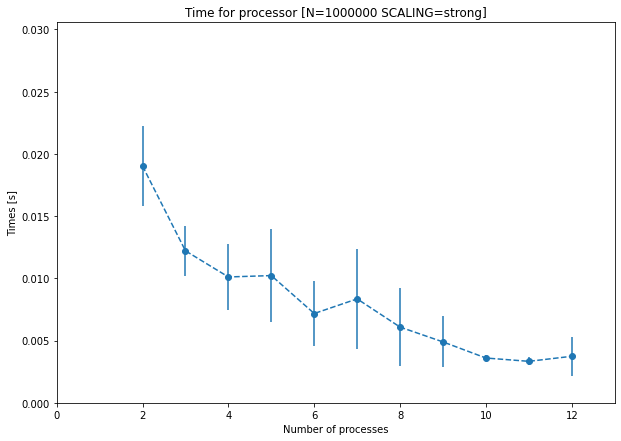

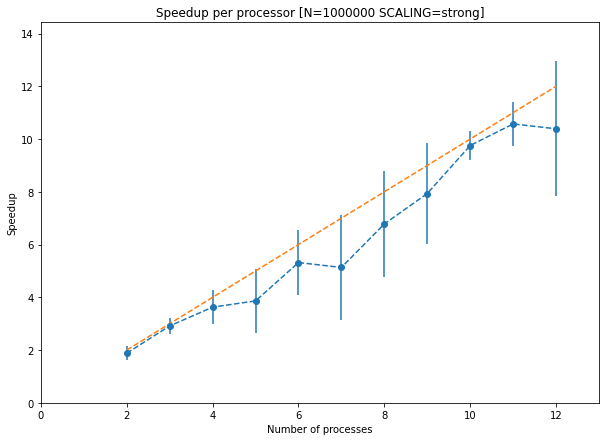

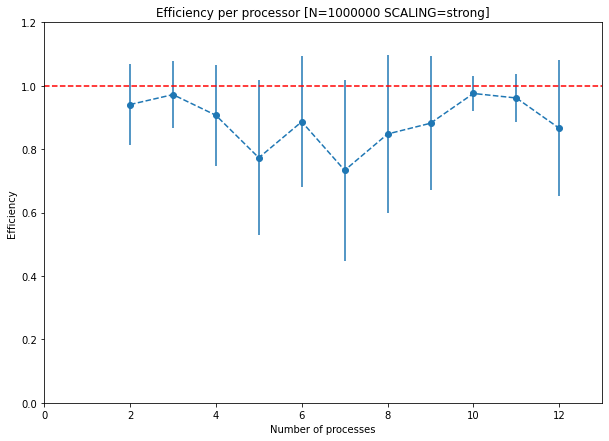

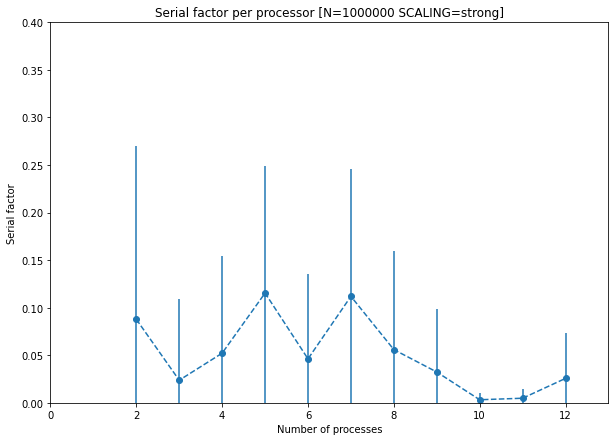

In [43]:
show_graphs_for_one_configuration(pi_results, "strong", 1000000)


Powyższe wykresy jasno pokazują, że milion punktów jest już wystarczająco dużym zbiorem danych, aby odnieść korzyści ze zrównoleglenia przedstawionego problemu. Nie będzie ono jednak konsystentne. Zmierzone wartości przyśpieszenia, efektywności i części sekwencyjnej, wyróżniające się wysokim odchyleniem standardowym, wyraźnie pokazują, że dla analizowanego rozmiaru problemu nie można spodziewać się za każdym razem równie dobrych wyników zrównoleglenia.

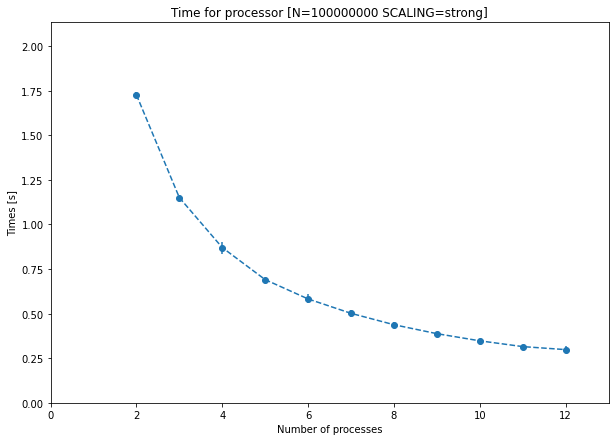

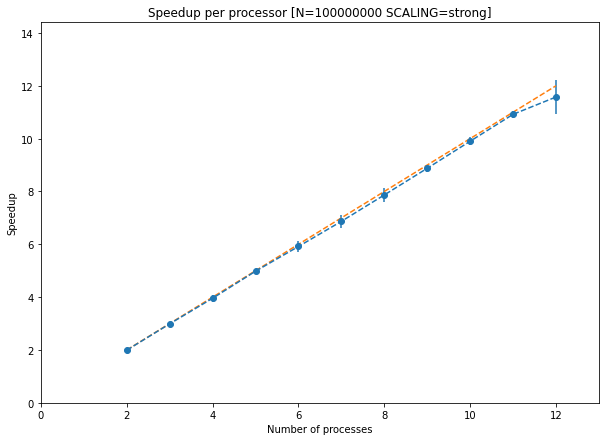

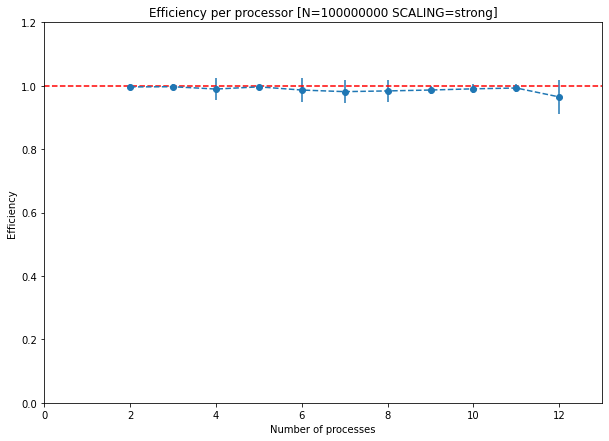

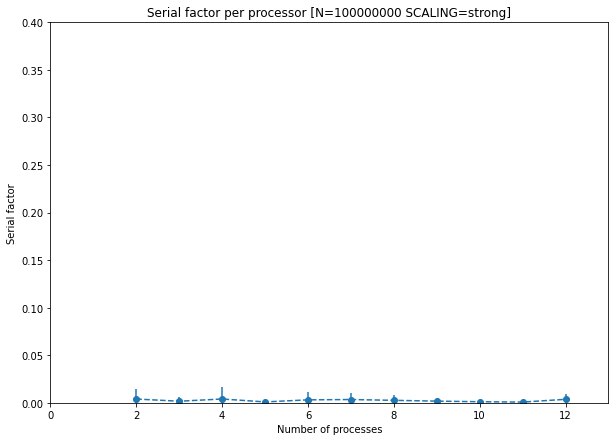

In [44]:
show_graphs_for_one_configuration(pi_results, "strong", 100000000)


Wyniki dla stu milionów punktów są zdecydowanie bardziej obiecujące niż w przypadku miliona. Wykres czasu ma wyraźną postać hiperboli, czego należy spodziewać się przy badaniu efektywności programu równoległego metodą Amdhala.

Wszystkie mierzone wartości dla niemal każdej liczby procesorów są podobne do idealnych. Jedyną liczbą procesorów, dla których nie jest to spełnione, jest 12. Można zaobserwować tam wyraźne odchylenie od wartości idealnej dla przyśpieszenia i efektywności. Jest to spowodowane większym nakładem czasu poświęconym na komunikację, której prawo Amdahla nie uwzględnia. Zgadza się to z oczekiwaniami.

##### N = 1410065408

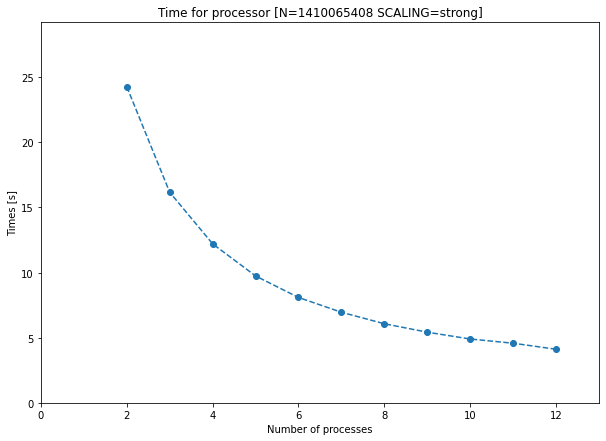

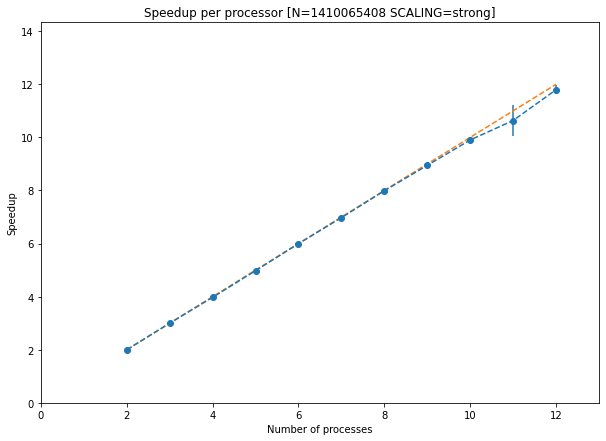

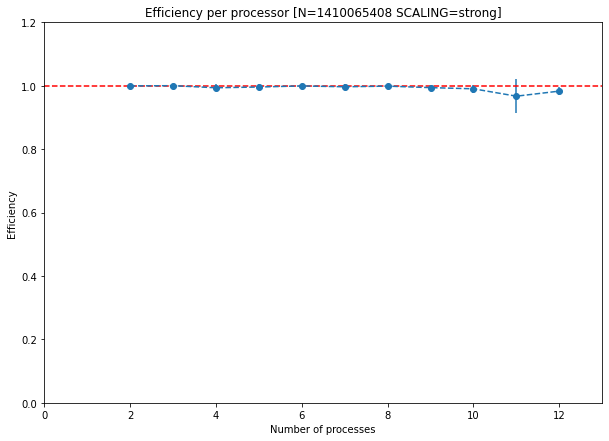

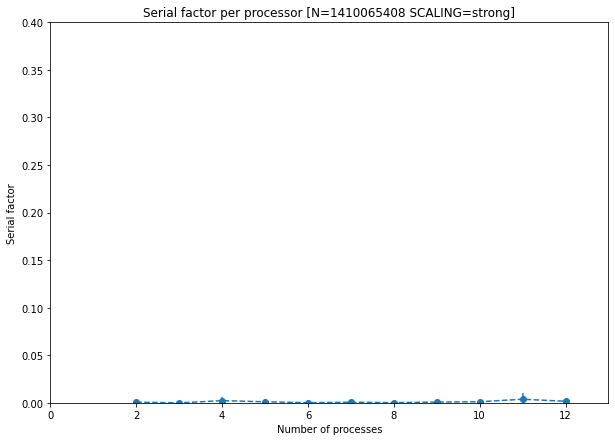

In [45]:
show_graphs_for_one_configuration(pi_results, "strong", 1410065408)


Dla wielkości problemu większej niż miliard możemy zaobserwować niemal idealne wyniki. Jedyne lekkie odstępstwo od normy można zaobserwować dla licby procesorów równej 11. Może być to spowodowane niespodziewanymi trudnościami związanymi z obecnym obciążeniem komputera, na którym testowano program.
Co istotne - również obserwujemy spadek przyśpieszenia i efektywności dla końcowych wartości (11 i 12 procesorów) jednak jest on zdecydowanie niższy niż w przypadku poprzednich wielkości problemów. 

#### Słaba skalowalność
Wyniki wyliczono wg prawa Gustavsona.

##### N = 1000000

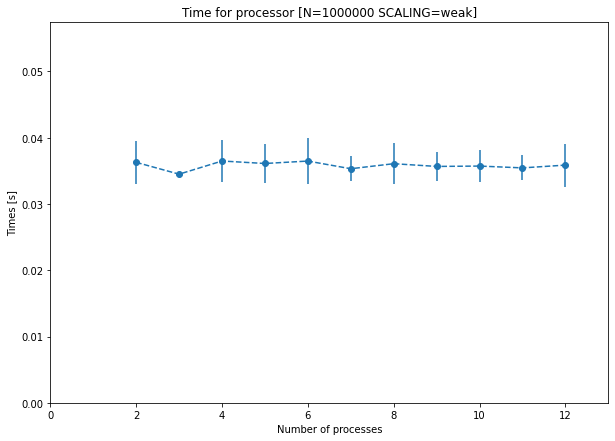

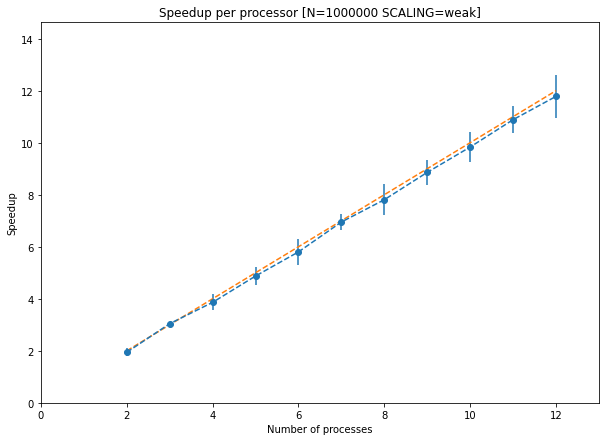

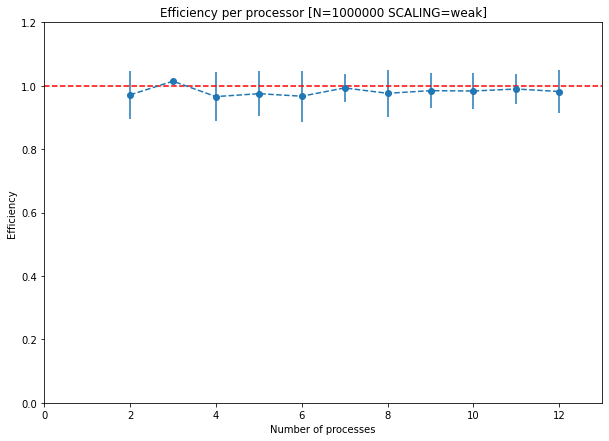

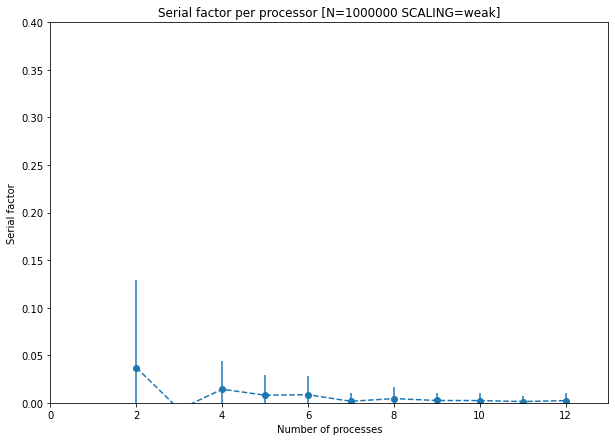

In [46]:
show_graphs_for_one_configuration(pi_results, "weak", 1000000)

Podobnie jak dla silnego skalowania, widzimy, że milion punktów to za mało, aby zaobserwować pełne i konsystentne korzyści ze zrównoleglenia. Koronnym przykładem jest *superskalarność* dla trzech procesorów, która najpewniej spowodowana jest błędami pomiarowymi, a nie rzeczywistym przyśpieszeniem ponad teoretyczną granicę.

Wartym zauważenia jest fakt, że wartości błędów pomiarowych przy badaniu zgodnie z prawem Gustavsona maleją wraz ze wzrostem liczby procesorów. Sprawia to, że pomiar dla wielkiej liczby procesorów tą metodą staje się o wiele lepszy niż dla metody Amdahla.

##### N = 10000000

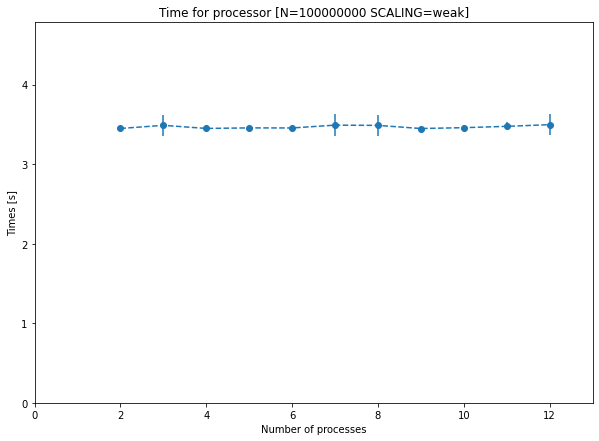

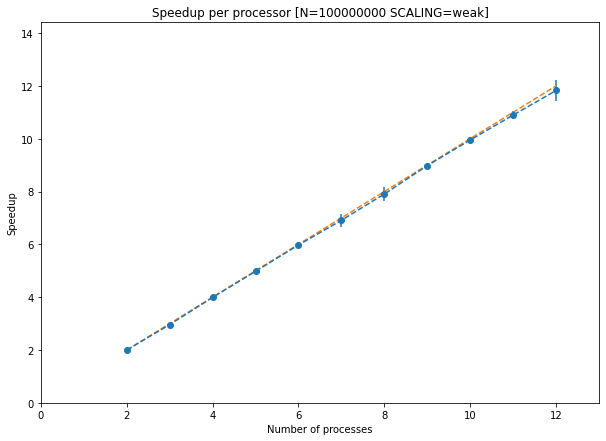

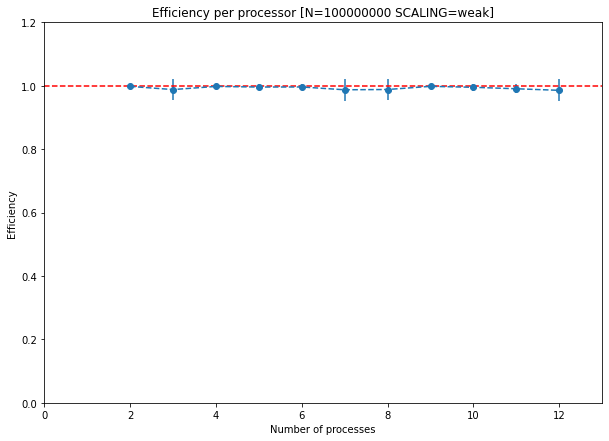

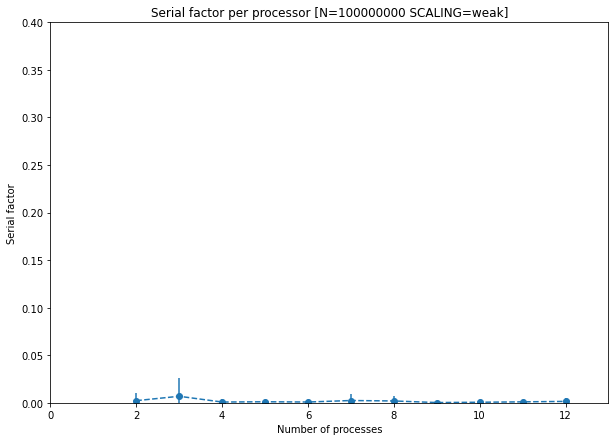

In [47]:
show_graphs_for_one_configuration(pi_results, "weak", 100000000)

Dla stumilionów punktów uzyskujemy niemal idealne wyniki. Czas jest niemal stały dla każdej liczby procesorów, a pozostałe wartości wyranie zbiegają do wartości idealnych. Nie obdserwujemy również *załamania* linii przyśpieszenia jak miało to miejsce w przypadku moncnej skalowalności. Jest to zgodne z oczekiwaniami.

##### N = 1410065408

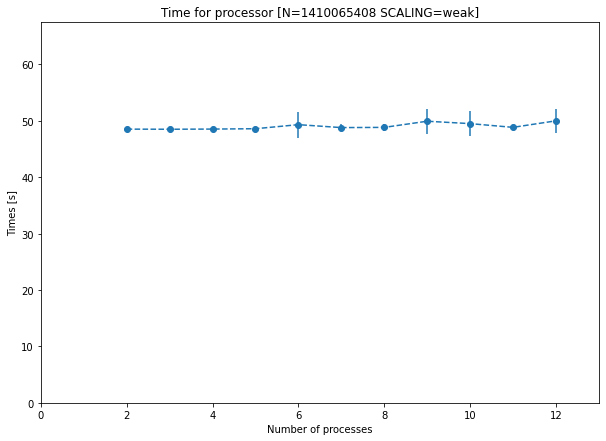

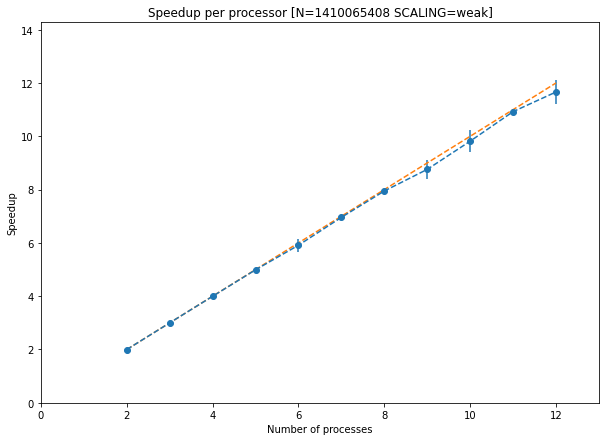

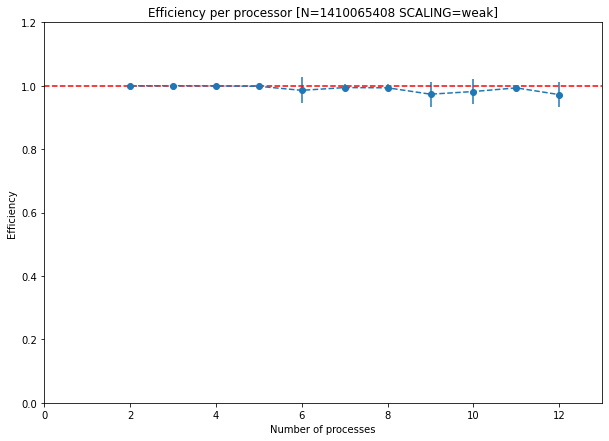

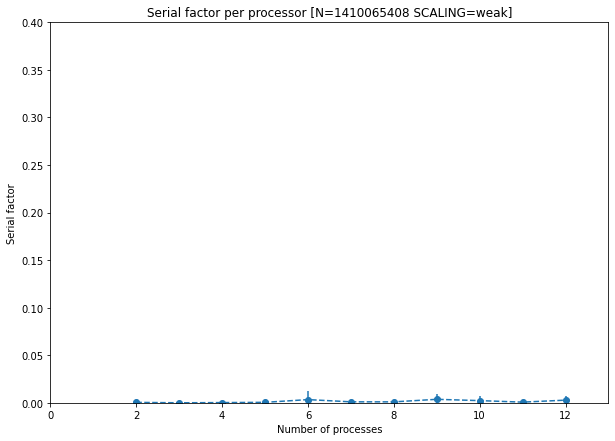

In [48]:
show_graphs_for_one_configuration(pi_results, "weak", 1410065408)

Dla ponad miliarda punktów wyniki również są zbliżone do idealnych. Niestety błedy pomiarowe na przedstawionych wyżej wykresach sa nieco większe niż w pozostałych. Najpewniej jest to spowodowane mniejszą liczbą powtórzeń eksperymentu (10 zamiast 15).

# Wnioski

Wyniki eksperymentów jasno pokazują, ze dla badanego problemu, zrównoleglenie wyraźnie wpływwa na szybsze wykonywanie programu lub dokładniejsze wyniki. 

Można wysnuć wniosek, że w przypadku problemów takich jak ten, tj. należących do grupy *embarassingly parallel*, zrównoleglanie może przyśpieszyć wykonanie programu nawet liniowo. Warto w takich przypadkach korzystać z możliwości zrównoleglania obliczeń.